### 使用协程，利用bh_videos_links.txt中提供的视频列表，进行对应视频文件（.mp4格式）的下载。

# 一

使用gevent + aiofiles 实现视频文件的下载，注意控制协程数目，避免服务器拒绝连接。

In [1]:
import gevent
from gevent import monkey
monkey.patch_all() # 打补丁，使得标准库异步化

import aiofiles
from geventhttpclient import httplib # geventhttpclient 是一个轻量级、高性能的 HTTP 客户端，适用于 gevent 环境
from geventhttpclient.client import HTTPClient
from geventhttpclient import client

import os
from urllib.parse import urlsplit # urlsplit() 函数用于将 URL 分解为各个组成部分

`fetch_video` 这是一个挨个从网上下载视频的函数

In [ ]:
def fecth_video(url, output_path):
    try:
        parsed = urlsplit(url)
        http_client = client.HTTPClient(parsed.hostname, port=parsed.port, ssl=(parsed.scheme == 'https'))
        response = http_client.get(parsed.path + ('?'+ parsed.query if parsed.query else ''))
        if response.status_code == 200:
            with open(output_path, 'wb')as f:
                while True:
                    chunk = response.read(1024*1024) # 1MB
                    if not chunk:
                        break
                    f.write(chunk)
            print('音频保存至{}'.format(output_path))
        else:
            print(f'下载失败:{url}，状态码:{response.status_code}')
    except Exception as e:
        print(f'下载出错：{url},错误:{e}')

从含有几百行url的 txt 文件里面将 URL 存储到数据结构里面

In [3]:
def get_url(file_path):
    with open(file_path,'r', encoding='utf-8')as f:
        url_ls = f.readlines()
    return url_ls

In [4]:
from gevent.pool import Pool

协程处理的主函数
- 如果文件不存在就下载视频
- 存在就skip
---
所以就看到输出中有很多 skip，是因为多次调试和终端下载

In [5]:
def main(maxworkers):
    file_path = '/Users/wtsama/Documents/code/python文件大型/week13/bh_videos_links.txt'
    output_dir = '/Users/wtsama/Documents/code/python文件大型/week13/video/'
    url_ls = get_url(file_path)
    
    pool = Pool(size=maxworkers)
    tasks = []
    
    for i, url in enumerate(url_ls):
        filename = "video_{}.mp4".format(i)
        output_path = os.path.join(output_dir, filename)
        if  os.path.exists(output_path):
            print("{} exists, skip".format(output_path))
            continue
        task = pool.spawn(fecth_video, url, output_path)
        tasks.append(task)
    
    gevent.joinall(tasks)
   

In [7]:
if __name__ == '__main__':
    main(maxworkers=10)

/Users/wtsama/Documents/code/python文件大型/week13/video/video_0.mp4 exists, skip
/Users/wtsama/Documents/code/python文件大型/week13/video/video_1.mp4 exists, skip
/Users/wtsama/Documents/code/python文件大型/week13/video/video_2.mp4 exists, skip
/Users/wtsama/Documents/code/python文件大型/week13/video/video_3.mp4 exists, skip
/Users/wtsama/Documents/code/python文件大型/week13/video/video_4.mp4 exists, skip
/Users/wtsama/Documents/code/python文件大型/week13/video/video_5.mp4 exists, skip
/Users/wtsama/Documents/code/python文件大型/week13/video/video_6.mp4 exists, skip
/Users/wtsama/Documents/code/python文件大型/week13/video/video_7.mp4 exists, skip
/Users/wtsama/Documents/code/python文件大型/week13/video/video_8.mp4 exists, skip
/Users/wtsama/Documents/code/python文件大型/week13/video/video_9.mp4 exists, skip
/Users/wtsama/Documents/code/python文件大型/week13/video/video_10.mp4 exists, skip
/Users/wtsama/Documents/code/python文件大型/week13/video/video_11.mp4 exists, skip
/Users/wtsama/Documents/code/python文件大型/week13/video/video_12.

# 二

使用aiohttp + aiofiles 实现视频文件的下载，注意控制协程数目，避免服务器拒绝连接。

注意文件有 518个

In [13]:
import aiohttp
import aiofiles
import asyncio
import os
from urllib.parse import urlsplit

import nest_asyncio
nest_asyncio.apply()

因为要调用async 而不是 gevent所以`fetch_video`写法有点变化

In [14]:
async def fetch_video2(session, url, output_file):
    try:
        async with session.get(url) as response:
            if response.status == 200:
                async with aiofiles.open(output_file, 'wb')as f:
                    async for chunk in response.content.iter_chunked(1024*1024):
                        await f.write(chunk)
                print('下载完成，保存到{}'.format(output_file))
            else:
                print('下载失败，状态码{}'.format(response.status))
    except Exception as e:
        print('下载失败，{}'.format(e))

In [16]:
def get_url_list(file_path):
    with open(file_path, 'r', encoding = 'utf-8') as f:
        return f.readlines()

调用`aiohttp`的主函数

In [17]:
async def main_async(maxworkers):
    file_path = '/Users/wtsama/Documents/code/python文件大型/week13/bh_videos_links.txt'
    output_dir = '/Users/wtsama/Documents/code/python文件大型/week13/video2/'
    url_ls = get_url_list(file_path)
    
    connector = aiohttp.TCPConnector(limit_per_host=10,ssl=False)
    semaphore = asyncio.Semaphore(maxworkers)
    
    async def limited_download(session, url, output_path):
        async with semaphore:
            await fetch_video2(session, url, output_path)
    
    async with aiohttp.ClientSession(connector=connector) as session:
        tasks = []
        for idx, url in enumerate(url_ls):
            filename = f'video_{idx}.mp4'
            if os.path.exists(os.path.join(output_dir, filename)):
                print(f'{filename} exists, skip')
                continue    
            task = asyncio.create_task(
                fetch_video2(session, url, os.path.join(output_dir, filename)))
            tasks.append(task)
        await asyncio.gather(*tasks)
    
    

这里已经运行通了，就不重复下载了；报错是因为手动停止

In [18]:
if __name__ == '__main__':
    asyncio.run(main_async(maxworkers=10))

/opt/anaconda3/envs/myenv2/lib/python3.12/site-packages/aiohttp/client.py:1424: RuntimeWarning: coroutine 'main_async' was never awaited
  async def __aenter__(self) -> _RetType:


下载失败，Cannot connect to host news.buaa.edu.cnhttp:443 ssl:default [nodename nor servname provided, or not known]
下载完成，保存到/Users/wtsama/Documents/code/python文件大型/week13/video2/video_0.mp4


KeyboardInterrupt: 

# 三

利用ffmpeg，获取所有视频文件的长度信息，并进行长度分布的可视化。

In [1]:
from ffmpy import FFmpeg

import subprocess
import json

In [2]:
def get_video_info(video_path):
    if not os.path.exists(video_path) or os.path.getsize(video_path) == 0:
        print(f"文件不存在或为空: {video_path}")
        return None
    
    cmd = [
            'ffprobe',  # ffprobe工具路径
            '-v', 'error',  # 只显示错误信息，减少输出的冗余
            '-print_format', 'json',  # 输出格式设置为JSON，便于解析
            '-show_format',  # 显示文件格式信息
            '-show_streams',  # 显示文件流信息
            video_path  # 需要分析的音视频文件路径
        ]
    try:
        # 运行 ffprobe 命令并捕获其输出结果。
        
        result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, check=True)
        info = json.loads(result.stdout)
        return info['format']['duration'] # str， 需要用float()转成float类型
    except subprocess.CalledProcessError as e:
        print("ffprobe 出错:", e.stderr)
        return None

用`concurrent.futures`模块的`ThreadPoolExecutor`类创建一个线程池便于得到结果进行后续操作。

In [3]:
from concurrent.futures import ThreadPoolExecutor
import os 
import sys

from pathlib import Path
import math

多线程分块进行

In [4]:
def process_chunk(chunk_lst):
    res = []
    for path in chunk_lst:
        filename = os.path.basename(path)
        filename = os.path.splitext(filename)[0]
        if not get_video_info(path):
            print('跳过无效文件{}'.format(path))
            continue
        res.append((filename, float(get_video_info(path))))
    return res

In [5]:
def slice_lst(lst, num_process):
    start = 0
    reminder = len(lst)%num_process
    chunk_size=math.ceil(len(lst)/num_process)
    threads=[]
    for i in range(num_process):
        end = start+chunk_size +(1 if reminder>i else 0)
        threads.append(lst[start:end])
        start=end
    return threads

这个函数 `process_all` 运行时间很久，大概 2、3 分钟

In [6]:
def process_all(dir_path, num_parts):
    dir_path = Path(dir_path)
    video_lst = []
    for f in dir_path.rglob('*.mp4'): # rglob('*') 递归匹配所有文件
        video_lst.append(str(f)) # 都是绝对路径
    chunk_lst = slice_lst(video_lst, num_parts)
    
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_chunk, part) for part in chunk_lst]
        # 接受所有结果
        results = []
        for future in futures:
            results.extend(future.result())
    print('************************************************\n')
    print('一共找到{}个有效视频文件'.format(len(results)))
    return results

In [ ]:
import matplotlib.pyplot as plt

画图，横轴是视频，纵轴是持续时间，柱状

In [ ]:
def draw(res):
    xs =[]
    ys =[]
    for item in res:
        xs.append(item[0])
        ys.append(item[1])
    max_y = max(ys)
    min_y = min(ys)
    
    if not ys:
        print('没有可以画图的数据')
    # mac系统中中文字体路径
    plt.bar(xs, ys, color = 'red')
    plt.ylim(min_y-0.5, max_y+0.5)
    plt.xlabel('video name')
    plt.ylabel('duration(s)')
    plt.title('{} videos and duration distribution'.format(len(res)))
    plt.xticks(rotation=90)
    
    plt.savefig('{} videos and duration distribution.png'.format(len(res)))
    plt.show()

第三题的主函数

In [ ]:
def main2():
    dir_path = '/Users/wtsama/Documents/code/python文件大型/week13/video/'
    num_parts = 10
    res = process_all(dir_path, num_parts)
    print('用于绘图的视频和长度:',res)
    draw(res)

- 这里运行结果，发现有 15 个文件有问题，文件得不到重要信息，就跳过了，有可能是下载的过程中出现了问题（网络不太好）；看似报错实际上是因为添加了异常处理，运行过程是跑通了的。
- 将得到的 503 个文件进行了绘图。图片x轴是一片黑是因为文字太密集了，后面我们单独统计文件长度信息。

ffprobe 出错: [mov,mp4,m4a,3gp,3g2,mj2 @ 0x7f95b440a200] moov atom not found
/Users/wtsama/Documents/code/python文件大型/week13/video/video_517.mp4: Invalid data found when processing input

跳过无效文件/Users/wtsama/Documents/code/python文件大型/week13/video/video_517.mp4
ffprobe 出错: [mov,mp4,m4a,3gp,3g2,mj2 @ 0x7fbeafc07900] moov atom not found
/Users/wtsama/Documents/code/python文件大型/week13/video/video_513.mp4: Invalid data found when processing input

跳过无效文件/Users/wtsama/Documents/code/python文件大型/week13/video/video_513.mp4
ffprobe 出错: [mov,mp4,m4a,3gp,3g2,mj2 @ 0x7f87968058c0] moov atom not found
/Users/wtsama/Documents/code/python文件大型/week13/video/video_333.mp4: Invalid data found when processing input

跳过无效文件/Users/wtsama/Documents/code/python文件大型/week13/video/video_333.mp4
ffprobe 出错: [mov,mp4,m4a,3gp,3g2,mj2 @ 0x7f8ea0a09940] moov atom not found
/Users/wtsama/Documents/code/python文件大型/week13/video/video_337.mp4: Invalid data found when processing input

跳过无效文件/Users/wtsama/Documents/code/python

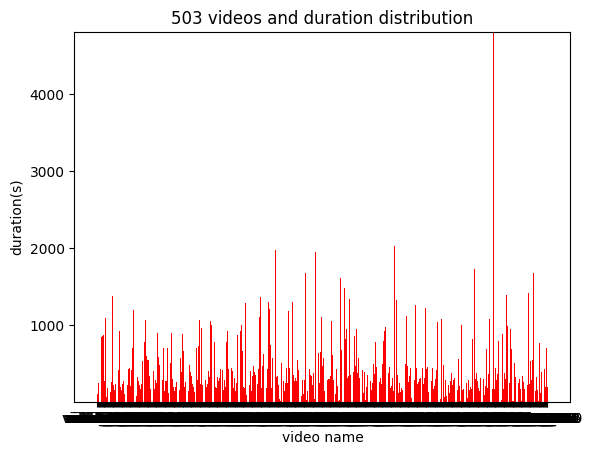

In [18]:
if __name__=="__main__":
    main2()

# 四

参考ali_video.py，选择少量的长度较短的视频（10个左右），利用视觉大模型进行视频内容的理解；根据输出的文本，进一步利用大模型（如deepseek)进一步总结所采集视频的主题有哪些。

避免多次调用process_all处理结果

In [36]:
def cache_results(dir_path):
    res = process_all(dir_path, num_parts=10)
    with open('cache.py', 'w', encoding='utf-8')as f:
        f.write(f'res={res}')
    print('results of process_all saved to cache.py')

In [37]:
cache_results('/Users/wtsama/Documents/code/python文件大型/week13/video/')

ffprobe 出错: [mov,mp4,m4a,3gp,3g2,mj2 @ 0x7fc79ea0ddc0] moov atom not found
/Users/wtsama/Documents/code/python文件大型/week13/video/video_517.mp4: Invalid data found when processing input

跳过无效文件/Users/wtsama/Documents/code/python文件大型/week13/video/video_517.mp4
ffprobe 出错: [mov,mp4,m4a,3gp,3g2,mj2 @ 0x7fa368904f00] moov atom not found
/Users/wtsama/Documents/code/python文件大型/week13/video/video_513.mp4: Invalid data found when processing input

跳过无效文件/Users/wtsama/Documents/code/python文件大型/week13/video/video_513.mp4
ffprobe 出错: [mov,mp4,m4a,3gp,3g2,mj2 @ 0x7fd8987064c0] moov atom not found
/Users/wtsama/Documents/code/python文件大型/week13/video/video_333.mp4: Invalid data found when processing input

跳过无效文件/Users/wtsama/Documents/code/python文件大型/week13/video/video_333.mp4
ffprobe 出错: [mov,mp4,m4a,3gp,3g2,mj2 @ 0x7f80037057c0] moov atom not found
/Users/wtsama/Documents/code/python文件大型/week13/video/video_337.mp4: Invalid data found when processing input

跳过无效文件/Users/wtsama/Documents/code/python

- 由于变量results包含所有有效文件的长度信息和文件名称，所以为了避免每次调试加载就储存在`cache.py`文件中，作为模块调用
- 由于视频大模型不能理解超长的视频，从第九长的视频就出错，选取了前八个

In [ ]:
def sort_len(dir_path):
    '''
    获取前八个最短的视频'''
    if os.path.exists('cache.py'):
        from cache import res
        sorted_res = sorted(res, key = lambda x:x[1])
        min_8 = sorted_res[:8]
        print('min_8: ',min_8)
        return min_8
    return None

In [23]:
from dashscope import MultiModalConversation
from dotenv import load_dotenv
load_dotenv()

True

从`.env`文件中加载 `api_key`

In [24]:
api_key = os.getenv("DASHSCOPE_API_KEY")

同样，由于每次调试都调用大模型很费事费钱，所以把输出一个一个存在一个文本里了，有八个文本。

In [ ]:
def call_video_model(dir_path):
    '''
    调用视频模型理解每个视频
    参数：dir_path，第一题存储视频的文件路径
    返回：texts，所有视频的文字列表'''
    min_8 = sort_len(dir_path) if sort_len(dir_path) else 0
    texts =[]
    for item in min_8:
        file = item[0]
        file = file + '.mp4'
        file = os.path.join(dir_path, file)
        print('调用大模型理解视频-{}'.format(item[0]))
        message = [{'role': 'system',
                'content': [{'text': 'You are a helpful assistant.'}]},
                {'role':'user',
                # fps参数控制视频抽帧数量，表示每隔1/fps 秒抽取一帧
                # txt为指令
                'content': [{'video': file,"fps":2},
                            {'text': '详细描述视频内容。'}]}]
        response = MultiModalConversation.call(
        api_key = api_key,
        model = 'qwen-vl-max-latest',  
        messages = message)
        
        text = response["output"]["choices"][0]["message"].content[0]["text"]
        print('type of text: ',type(text))
        
        with open('{}.txt'.format(item[0]),'w',encoding='utf-8')as f:
            f.write(text)
        print('保存视频描述文件到{}.txt'.format(item[0]))
        
        file = item[0]
        texts.append(file+':'+text+'\n')
    
        
    return texts

考虑到成本原则，就一次性调用直接存储了，没有进行封装，实际上是运行通过了的
见截图

In [ ]:
dir_path = '/Users/wtsama/Documents/code/python文件大型/week13/video/'
texts = call_video_model(dir_path)

In [25]:
import os
from openai import OpenAI

用deepseek进行理解输出的文本，一次性理解所有，总结主题

In [26]:
def call_deepseek(desciption):
    
    client = OpenAI(
        api_key=api_key,  # 如何获取API Key：https://help.aliyun.com/zh/model-studio/developer-reference/get-api-key
        base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"
    )
    print('调用 ds 理解————')
    completion = client.chat.completions.create(
        model="deepseek-r1-distill-llama-70b",# 限时免费  # 此处以 deepseek-r1 为例，可按需更换模型名称。
        messages=[
            {'role': 'user', 'content': '请你帮我提取文本的主题，总结这些主题有哪些：{}'.format(desciption)}
        ]
    )

    # 通过reasoning_content字段打印思考过程
    print("思考过程：")
    print(completion.choices[0].message.reasoning_content)

    # 通过content字段打印最终答案
    print("最终答案：")
    print(completion.choices[0].message.content)

这个函数`sum_themes`是将所有的文本理解加成成一个长字符串喂给 ds的,`dir_path`是视频的目录

In [32]:
def sum_themes(dir_path):
    sl = sort_len(dir_path)
    min_8 = sl if sl else 0
    texts = []
    for item in min_8:
        file = item[0]
        file_path = file+'.txt'
        with open(file_path, 'r', encoding='utf-8') as f:
            texts.append('{}的内容:'.format(item[0])+f.read()+'\n')
    print('输入视频的数量:',len(texts))
    return ''.join(texts)+'注意，输入的视频有{}个'.format(len(texts))


一个主函数，对应第四题

In [33]:
def main4():
    dir_path = '/Users/wtsama/Documents/code/python文件大型/week13/video/'
    texts = sum_themes(dir_path)
    call_deepseek(texts)

In [34]:
if __name__ == '__main__':
    main4()

min_8:  [('video_4', 14.720998), ('video_46', 17.879002), ('video_0', 19.132993), ('video_48', 24.938005), ('video_467', 25.12), ('video_511', 26.56), ('video_3', 27.539002), ('video_500', 27.88)]
输入视频的数量: 8
调用 ds 理解————
思考过程：
嗯，我现在要帮用户提取文本中的主题，并总结这些主题。用户给了我8个视频的内容，每个视频都有详细的描述。我需要仔细阅读每个视频的内容，找出它们的主题，然后进行分类和总结。

首先，我来看看每个视频的基本信息：

video_4：校园春天的美景，展示了九宫格照片、动态过渡、校园景色和结尾画面，突出北京航空航天大学的春天。

video_46：拔河比赛，户外活动，参赛队伍、裁判、摄影师，比赛过程，团队精神和观众热情。

video_0：姜铁红教授的专题讲座，在北航美育大讲堂，讲座内容是关于舞蹈《奔腾》的美学表达，现场教学和观众反应。

video_48：校园体育活动，包括绕杆跑、跳高、平衡木、拔河、排球、接力赛、篮球、壶铃训练和集体活动，展示多样性和团队合作。

video_467：月宫365实验，模拟封闭环境中的生存条件，展示实验舱内部、植物培养、日常生活、生命保障系统、健康监测和锻炼。

video_511：创新创业大赛，在西安举行，会场环境、演讲与展示、具体内容、评委与嘉宾、氛围和媒体标识，突出科技创新。

video_3：怀念老院长，通过海棠花的景象，回忆沈元老院长，展示海棠树的象征意义和北航的发展历史。

video_500：中法工程师学院的企业开放日，致辞、观众反应、现场互动、学生表演和合影，促进中法合作。

接下来，我需要从每个视频中提取主题：

video_4：校园春天、自然美景、北京航空航天大学。

video_46：拔河比赛、团队精神、校园活动、体育竞技。

video_0：舞蹈艺术、美育讲座、文化传承、姜铁红。

video_48：校园体育、多样性活动、团队合作、青春活力。

video_467：封闭生存实验、科学研究、月宫365、可持续生存。

video_511：创新创业、科技比赛、教育活动、北航全球